# About

This is an example of constructing a data scrapper that is capable of going down a given website N levels deep and scraping the text on the webpage. It uses Selenium and BeautifulSoup to grab html and parse it. It also uses networkx and matplotlib to construct a graph of the traversals it does to the given web pages.

The purpose of creating this is to feed be able to scrape website pages that can be then used with OpenAIs embeddings API to be used in conjuction with ChatGPT when LLMs are desired to be used when knowledge isnt available past a certain models date i.e.: 3.5, 2021.

In [281]:
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.options import Options
from pydantic import BaseModel
from typing import Optional

import networkx as nx
import matplotlib.pyplot as plt
import uuid

class Job(BaseModel):
    href: str
    depth: int
    parent: Optional[str]

    def __hash__(self):
        return hash((self.href))

    def __eq__(self, other):
        if not isinstance(other, Job):
            return False
        return self.href == other.href


class DataScrapper():
    """
    Class given a starting url, and base url, is capable of scraping a website to N levels deep.
    """
    def __init__(self, url, base_url, max_depth):
        self.url = url
        self.base_url = base_url
        self.max_depth = max_depth
        self.reset_dependencies()

    def _create_driver(self):
        """
        Creates chrome web driver to grab html.
        :return: Driver
        """
        chrome_options = Options()
        chrome_options.add_argument('--headless')
        driver = webdriver.Chrome(options=chrome_options)
        return driver

    def get_page_html(self, url):
        """
        Using the chrome driver grabs urls html and returns it.
        
        :param url: 
        :return: 
        """
        self.driver.get(url)
        html = self.driver.page_source
        return html

    def draw_graph(self):
        """
        Used to draw a graph of the sites visited where each node is a given page and edges to new
        nodes are links from a page to a new page.
        
        :return: 
        """
        nx.draw(self.graph, with_labels=True, node_size=200, node_color='skyblue', font_size=10)
        plt.title('Data Scrapper Visual')
        plt.show()


    def reset_dependencies(self):
        """Reinitializes dependencies to run a new scrape job."""
        self.driver = self._create_driver()
        self.graph = nx.DiGraph()
        self.visited = set()

    def add_host_if_needed(self, link):
        """If link doesnt contain hostname in link we adjust it with starting hostname."""
        href = link['href']
        if not href.startswith('http'):
            href = self.url + href
        return href

    def add_links_to_queue(self, links, curr_job, queue, path):
        """Given a webpages links we add them to the queue list if
            1. link is within same host
            2. link hasnt been visited
            3. new link doesnt violate max depth        
        """
        for link in links:
            href = self.add_host_if_needed(link)
            if (href not in self.visited and
                    self.base_url in href and
                    curr_job.depth + 1 < self.max_depth) :
                job = Job(href=href, depth=curr_job.depth + 1, parent=path)
                queue.add(job)

    def add_edge_to_graph(self, curr_job, path):
        """
        Add a new node to the graph.
        
        :param curr_job: 
        :param path: 
        :return: 
        """
        if curr_job.parent:
            self.graph.add_edge(curr_job.parent, path)

    def scrape(self, depth, parsed_documents):
        """
        We set up a starting job where to start and do a BFS search down the website iteratively.
        
        We also build a graph along the way.
        :param depth: 
        :param parsed_documents: 
        :return: 
        """
        initial_job = Job(href=self.url, depth=depth, parent=None)
        queue: set[Job] = set()
        queue.add(initial_job)
        while queue:
            curr_job = queue.pop()
            try:
                self.visited.add(curr_job.href)
                path = uuid.uuid4().hex[:4]
                self.add_edge_to_graph(curr_job, path)
                html = self.get_page_html(curr_job.href)
                parser = BeautifulSoup(html, 'html.parser')
                parsed_documents.append({
                    "url": curr_job.href,
                    "content": parser.get_text()
                })
                links = parser.find_all('a', href=True)
                self.add_links_to_queue(links, curr_job, queue, path)
                print(f"queue {len(queue)} seen {len(self.visited)}")

            except Exception as e:
                self.visited.add(curr_job.href)



With the definition of the class that handles the datascrapping out of the way, we can now initialize an instance of it aimed at a website that contains health insurance info for California.

We initialize it with the website and max depth of 3 pages from the root for it to scrape from.

We also provide it with a empty list for it to populate results to.

In [282]:
url = 'https://www.healthforcalifornia.com'
parsed_documents = []
base_url = 'healthforcalifornia'
scrapper = DataScrapper(url, base_url, max_depth=3)
scrapper.scrape(0, parsed_documents)


queue 27 seen 1
queue 29 seen 2
queue 29 seen 3
queue 28 seen 4
queue 34 seen 5
queue 41 seen 6
queue 38 seen 9
queue 38 seen 10
queue 37 seen 11
queue 42 seen 12
queue 50 seen 13
queue 49 seen 14
queue 50 seen 15
queue 57 seen 16
queue 56 seen 17
queue 55 seen 18
queue 54 seen 19
queue 53 seen 20
queue 52 seen 21
queue 51 seen 22
queue 50 seen 23
queue 49 seen 24
queue 48 seen 25
queue 47 seen 26
queue 47 seen 27
queue 46 seen 28
queue 45 seen 29
queue 44 seen 30
queue 43 seen 31
queue 53 seen 32
queue 52 seen 33
queue 51 seen 34
queue 50 seen 35
queue 50 seen 36
queue 49 seen 37
queue 48 seen 38
queue 47 seen 39
queue 46 seen 40
queue 44 seen 42
queue 43 seen 43
queue 42 seen 44
queue 46 seen 45
queue 45 seen 46
queue 44 seen 47
queue 43 seen 48
queue 42 seen 49
queue 46 seen 50
queue 45 seen 51
queue 44 seen 52
queue 43 seen 53
queue 42 seen 54
queue 41 seen 55
queue 40 seen 56
queue 39 seen 57
queue 38 seen 58
queue 37 seen 59
queue 36 seen 60
queue 35 seen 61
queue 34 seen 62
queu

We can first draw the graph of how the traversal came about looking. 

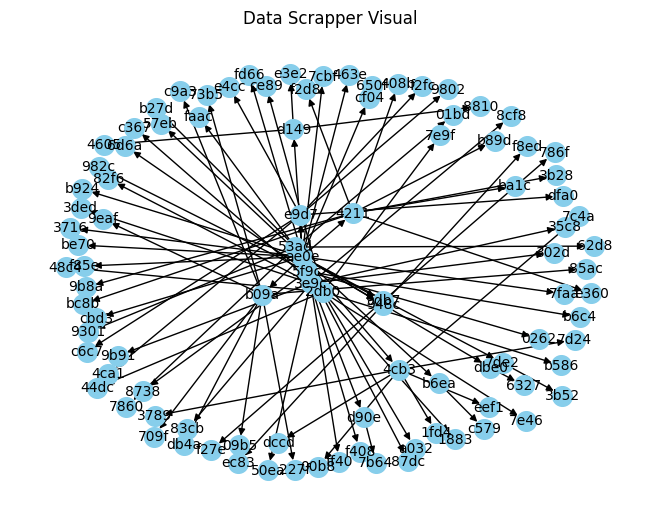

In [283]:
scrapper.draw_graph()

Now that we have the generated documents. We have an array populated with dictionaries. Each dictionary contains the url and content of that url. We first check how many results we attained.

In [284]:
len(parsed_documents)

94

Now what we want to do is see how much unique content we have. There is a case that some urls may point to the same content, so we will group the results by the content in key value pairs as such "<content>": [<url1> <url2>]

In [285]:
content_to_urls = {}

for item in parsed_documents:
    if item['content'] in content_to_urls:
        content_to_urls[item['content']].append(item['url'])
    else:
        content_to_urls[item['content']] = [item['url']]


Now we want to see how many of the results had duplicates and how many how many only had one result.

In [286]:
total_over_1 = 0
equal_1 = 0

for key, value in content_to_urls.items():
    if len(value) > 1:
        total_over_1 +=1
    elif len(value) == 1:
        equal_1 += 1
print(f"Results with duplicates: {total_over_1}")
print(f"Results with one match: {equal_1}")

Results with duplicates: 5
Results with one match: 75
